In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Importing libraries

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage import transform
import csv

In [0]:
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Activation, Flatten, Reshape
from keras.models import Model

Using TensorFlow backend.


In [0]:
%matplotlib inline

## Reading images

In [0]:
dataset_path = '/content/gdrive/My Drive/Colab Notebooks/faces94/faces94'

In [0]:
class_labels = map(lambda path: path.split('/')[-1], glob.glob(dataset_path+'/*'))

In [0]:
encoded_images = []

for class_label in class_labels:
    encoded_images += [[class_label,]]*len(glob.glob(dataset_path+'/{}/*/*.jpg'.format(class_label)))

In [0]:
image_files = glob.glob(dataset_path+'/*/*/*.jpg')

print(len(image_files))

3040


In [0]:
image_shape = (128, 128, 3)

## Scaling and normalzing images

In [0]:
images = np.array([transform.resize(plt.imread(image_file), output_shape=image_shape, preserve_range=True) for image_file in image_files], dtype='float32')/255.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Encoder model

In [0]:
input_placeholder = Input(image_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_placeholder)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encode = Dense(100, activation='tanh')(x)

Instructions for updating:
Colocations handled automatically by placer.


## Decoder model

In [0]:
y = Dense(128, activation="relu")(encode)
y = Dense(256*(image_shape[0]//8)*(image_shape[1]//8), activation='relu')(y)
y = Reshape((image_shape[0]//8, image_shape[1]//8, 256))(y)
y = BatchNormalization()(y)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(y)
x = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(y)
x = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same')(y)
y = BatchNormalization()(y)
y = UpSampling2D((2, 2))(y)
decode = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(y)

In [0]:
model = Model(input_placeholder, decode)
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['accuracy'])

## Shuffling data

In [0]:
idx = np.random.randint(0, len(images), len(images))
images = images[idx]

encoded_images = np.array(encoded_images)

encoded_images = encoded_images[idx]

## Adding noise to input for better training of autoencoder

In [0]:
noise_factor = 0.1
X = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
X = np.clip(X, 0. , 1.)

## Setting batch size and epochs

In [0]:
epochs=100
batch_size=64

## Training

In [0]:
r = model.fit(X, images,
batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 2432 samples, validate on 608 samples
Epoch 1/100
2432/2432 [==============================] - 26s 11ms/step - loss: 0.0384 - acc: 0.6247 - val_loss: 0.0247 - val_acc: 0.6583
Epoch 2/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0164 - acc: 0.7167 - val_loss: 0.0205 - val_acc: 0.6913
Epoch 3/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0106 - acc: 0.7658 - val_loss: 0.0157 - val_acc: 0.7081
Epoch 4/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0077 - acc: 0.7982 - val_loss: 0.0121 - val_acc: 0.7760
Epoch 5/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0063 - acc: 0.8159 - val_loss: 0.0142 - val_acc: 0.7851
Epoch 6/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0054 - acc: 0.8262 - val_loss: 0.0088 - val_acc: 0.7945
Epoch 7/100
2432/2432 [==============================] - 18s 7ms/step - loss: 0.0049 - a

## Plotting train and valid loss

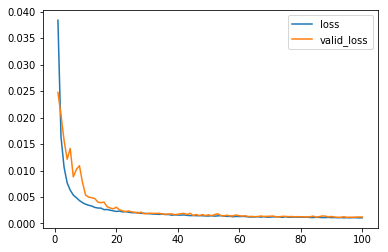

In [0]:
plt.plot(np.arange(1, epochs+1), r.history['loss'], label='loss')
plt.plot(np.arange(1, epochs+1), r.history['val_loss'], label='valid_loss')
plt.legend()

## Plotting train and valid accuracy

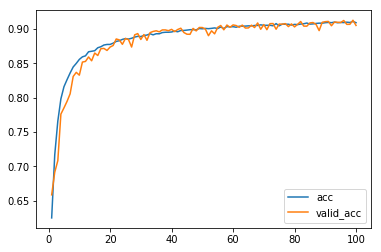

In [0]:
plt.plot(np.arange(1, epochs+1), r.history['acc'], label='acc')
plt.plot(np.arange(1, epochs+1), r.history['val_acc'], label='valid_acc')
plt.legend()

## Encoder model

In [0]:
encoded_model = Model(input_placeholder, encode)

## Input images, encoded images and reconstructed images

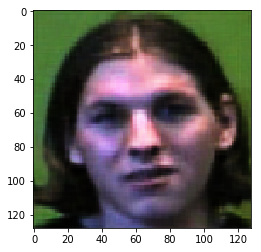

In [0]:
row, col = 1, 5
imgs = model.predict(images[:row*col])
imgs = 0.5 * imgs + 0.5
input_imgs = 0.5 * images[:row*col] + 0.5

plt.figure(figsize=(20, 4))
for i in range(row*col):
    plt.subplot(row, col, i+1)
    plt.imshow(input_imgs[i])

encoded_imgs = encoded_model.predict(images[:row*col]).reshape(-1, 50, 2)

plt.figure(figsize=(20, 4))
for i in range(row*col):
    plt.subplot(row, col, i+1)
    plt.imshow(encoded_imgs[i])

plt.figure(figsize=(20, 4))
for i in range(row*col):
    plt.subplot(row, col, i+1)
    plt.imshow(imgs[i])

## Creating a list of class label and encoded vector

In [0]:
outputs = encoded_model.predict(images)

label_encode_list = []

for i in range(len(outputs)):
    label_encode_list += [list(np.append(encoded_images[i], outputs[i]))]

## Writing to a csv file

In [0]:
with open('encoded.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(label_encode_list)

csvFile.close()

In [0]:
from google.colab import files
files.download('encoded.csv')